In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

IN_PATH = "../Circumplex Model/Output/mentalbert_28labels_with_va.csv"   # from previous step
OUT_DIR = "../Circumplex Model/Output/28 Labels"
import os; os.makedirs(OUT_DIR, exist_ok=True)

In [21]:
df = pd.read_csv(IN_PATH)
print(df.columns.tolist())
print(df[["subreddit","valence","arousal"]].head())

# Ensure required columns exist
assert "subreddit" in df.columns, "Missing 'subreddit' column."
assert "valence" in df.columns and "arousal" in df.columns, "Missing valence/arousal columns."

# Ensure valence/arousal in [0,1]
print(df[["valence","arousal"]].describe())

['subreddit', 'title', 'clean_text', 'url', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral', 'predicted_emotion', 'top3_emotions', 'valence', 'arousal', 'valence_norm', 'arousal_norm', 'quadrant']
  subreddit   valence   arousal
0      ADHD -0.053292 -0.599142
1      ADHD -0.655764  0.352825
2      ADHD -0.440758  0.185655
3      ADHD -0.360715 -0.133575
4      ADHD -0.052943 -0.619064
            valence       arousal
count  95250.000000  95250.000000
mean      -0.276041      0.018497
std        0.378989      0.382168
min       -0.868215     -0.628086
25%       -0.594999     -0.309134
50%       -0.316614      0.044488
75%       -0.063472      0.336387
max        0.984357      0.734714


In [22]:
sub_summary = (
    df.groupby("subreddit")
      .agg(mean_valence=("valence","mean"),
           mean_arousal=("arousal","mean"),
           n_posts=("subreddit","size"))
      .reset_index()
      .sort_values("mean_valence")
)
sub_summary_path = os.path.join(OUT_DIR, "subreddit_valence_arousal_summary.csv")
sub_summary.to_csv(sub_summary_path, index=False)
print(f"Saved → {sub_summary_path}")
sub_summary.head(10)

Saved → ../28 Labels/Circumplex Model/Output/subreddit_valence_arousal_summary.csv


,subreddit,mean_valence,mean_arousal,n_posts
5,HealthAnxiety,-0.368406,0.241976,5187
13,depression,-0.331110,0.044369,6254
6,MentalHealthSupport,-0.328634,0.039035,5593
16,mentalhealth,-0.322408,0.049125,5825
14,depression_help,-0.319518,0.034089,5488
3,AnxietyDepression,-0.316522,0.135227,5690
18,ptsd,-0.312043,0.007452,5991
19,socialanxiety,-0.310471,0.130882,6000
10,SuicideWatch,-0.309694,0.072528,5880
20,traumatoolbox,-0.290392,-0.061540,1532


Saved → ../28 Labels/Circumplex Model/Output/top15_most_negative_subreddits.png


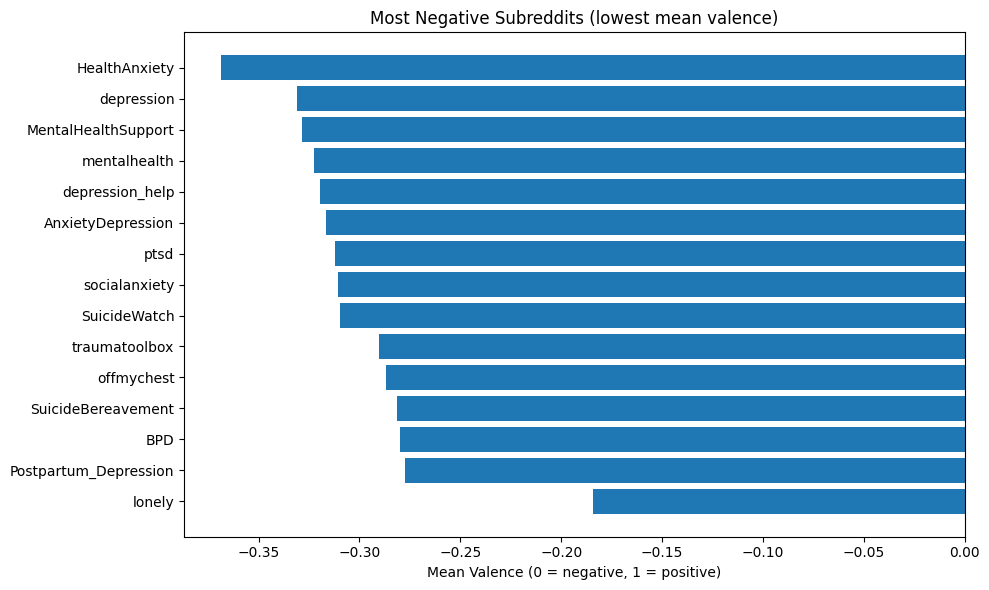

In [23]:
top_neg = sub_summary.sort_values("mean_valence").head(15)

plt.figure(figsize=(10,6))
plt.barh(top_neg["subreddit"], top_neg["mean_valence"])
plt.gca().invert_yaxis()
plt.title("Most Negative Subreddits (lowest mean valence)")
plt.xlabel("Mean Valence (0 = negative, 1 = positive)")
plt.tight_layout()

fig_path = os.path.join(OUT_DIR, "top15_most_negative_subreddits.png")
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
print(f"Saved → {fig_path}")
plt.show()

Saved → ../28 Labels/Circumplex Model/Output/top15_highest_arousal_subreddits.png


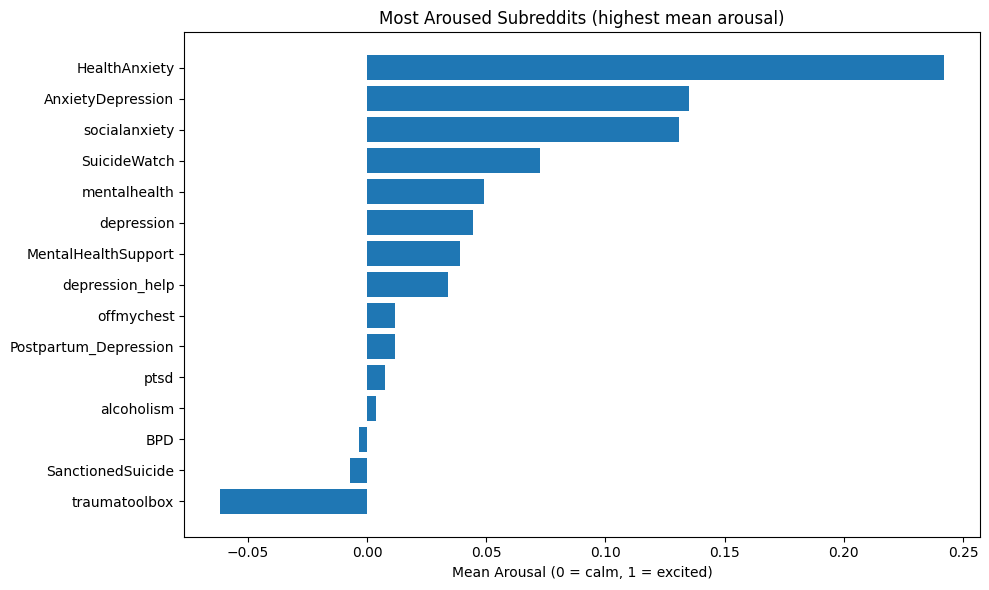

In [24]:
top_arousal = sub_summary.sort_values("mean_arousal", ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top_arousal["subreddit"], top_arousal["mean_arousal"])
plt.gca().invert_yaxis()
plt.title("Most Aroused Subreddits (highest mean arousal)")
plt.xlabel("Mean Arousal (0 = calm, 1 = excited)")
plt.tight_layout()

fig_path = os.path.join(OUT_DIR, "top15_highest_arousal_subreddits.png")
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
print(f"Saved → {fig_path}")
plt.show()

In [25]:
import numpy as np

# 1) Assign quadrants using valence & arousal (≈ −1 → +1 scale)
def quadrant(v, a):
    if np.isnan(v) or np.isnan(a):
        return "NA"
    if v >= 0 and a >= 0:
        return "Q1_Pos_High"      # Positive–High Arousal
    if v >= 0 and a < 0:
        return "Q2_Pos_Low"       # Positive–Low Arousal
    if v < 0 and a < 0:
        return "Q3_Neg_Low"       # Negative–Low Arousal
    return "Q4_Neg_High"          # Negative–High Arousal

df["quadrant"] = [quadrant(v, a) for v, a in zip(df["valence"], df["arousal"])]

# 2) Build counts via pivot_table
tmp = df.assign(_ones=1)
quad_counts = tmp.pivot_table(
    index="subreddit",
    columns="quadrant",
    values="_ones",
    aggfunc="sum",
    fill_value=0
)

# 3) Convert counts → proportions
row_sums = quad_counts.sum(axis=1).replace(0, np.nan)
quad_prop = (quad_counts.div(row_sums, axis=0)).fillna(0).round(4)

# 4) Ensure consistent columns
for col in ["Q1_Pos_High", "Q2_Pos_Low", "Q3_Neg_Low", "Q4_Neg_High"]:
    if col not in quad_prop.columns:
        quad_prop[col] = 0.0

quad_prop = quad_prop[["Q3_Neg_Low", "Q4_Neg_High", "Q2_Pos_Low", "Q1_Pos_High"]].reset_index()

# 5) Save + preview
quad_prop_path = os.path.join(OUT_DIR, "subreddit_quadrant_proportions.csv")
quad_prop.to_csv(quad_prop_path, index=False)
print(f"✅ Saved → {quad_prop_path}")
quad_prop.head(10)

✅ Saved → ../28 Labels/Circumplex Model/Output/subreddit_quadrant_proportions.csv


quadrant,subreddit,Q3_Neg_Low,Q4_Neg_High,Q2_Pos_Low,Q1_Pos_High
0,ADHD,0.4918,0.2905,0.1034,0.1143
1,ADHD_Programmers,0.5324,0.1734,0.1450,0.1493
2,ADHDparenting,0.6026,0.2024,0.1175,0.0774
3,AnxietyDepression,0.2817,0.5529,0.0633,0.1021
4,BPD,0.4146,0.4323,0.0618,0.0913
5,HealthAnxiety,0.2194,0.6576,0.0447,0.0783
6,MentalHealthSupport,0.3860,0.4713,0.0590,0.0837
7,Postpartum_Depression,0.4027,0.4082,0.0815,0.1076
8,SanctionedSuicide,0.3897,0.3690,0.0845,0.1569
9,SuicideBereavement,0.5244,0.2809,0.0755,0.1192


✅ Saved plot → ../28 Labels/Circumplex Model/Output/quadrant_mix_by_subreddit.png


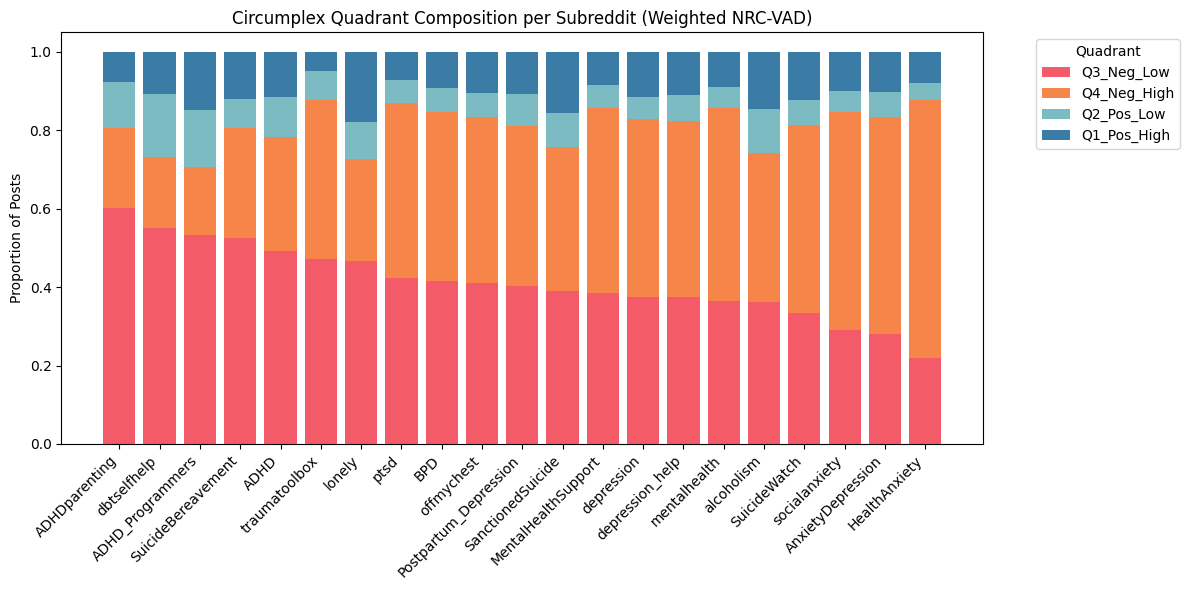

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Read the proportions table if not already loaded
quad_prop = pd.read_csv(os.path.join(OUT_DIR, "subreddit_quadrant_proportions.csv"))

# Sort by most negative (Q3_Neg_Low)
quad_prop = quad_prop.sort_values("Q3_Neg_Low", ascending=False)

# Prepare for stacked bar
cols = ["Q3_Neg_Low", "Q4_Neg_High", "Q2_Pos_Low", "Q1_Pos_High"]
colors = ["#f45b69", "#f58549", "#7dbbc3", "#3a7ca5"]

plt.figure(figsize=(12,6))
bottom = np.zeros(len(quad_prop))
for col, color in zip(cols, colors):
    plt.bar(quad_prop["subreddit"], quad_prop[col], bottom=bottom, label=col, color=color)
    bottom += quad_prop[col]

plt.title("Circumplex Quadrant Composition per Subreddit (Weighted NRC-VAD)")
plt.ylabel("Proportion of Posts")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Quadrant", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()

fig_path = os.path.join(OUT_DIR, "quadrant_mix_by_subreddit.png")
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
print(f"✅ Saved plot → {fig_path}")
plt.show()


In [27]:
# Simple “negative” = Q3 + Q4; “positive” = Q1 + Q2
quad_prop["negative_share"] = (quad_prop["Q3_Neg_Low"] + quad_prop["Q4_Neg_High"]).round(3)
quad_prop["positive_share"] = (quad_prop["Q2_Pos_Low"] + quad_prop["Q1_Pos_High"]).round(3)

# Sort descending by negative share
ranked = quad_prop.sort_values("negative_share", ascending=False)
ranked_cols = ["subreddit", "negative_share", "positive_share"]
print("Top 10 subreddits by negative emotional share:")
print(ranked[ranked_cols].head(10).to_string(index=False))

ranked_path = os.path.join(OUT_DIR, "subreddit_neg_pos_ranking.csv")
ranked[ranked_cols].to_csv(ranked_path, index=False)
print(f"✅ Saved → {ranked_path}")

Top 10 subreddits by negative emotional share:
          subreddit  negative_share  positive_share
      HealthAnxiety           0.877           0.123
      traumatoolbox           0.877           0.123
               ptsd           0.871           0.129
MentalHealthSupport           0.857           0.143
       mentalhealth           0.856           0.144
                BPD           0.847           0.153
      socialanxiety           0.846           0.154
  AnxietyDepression           0.835           0.165
         offmychest           0.835           0.165
         depression           0.829           0.171
✅ Saved → ../28 Labels/Circumplex Model/Output/subreddit_neg_pos_ranking.csv


✅ Saved heatmap → ../28 Labels/Circumplex Model/Output/quadrant_heatmap_by_subreddit.png


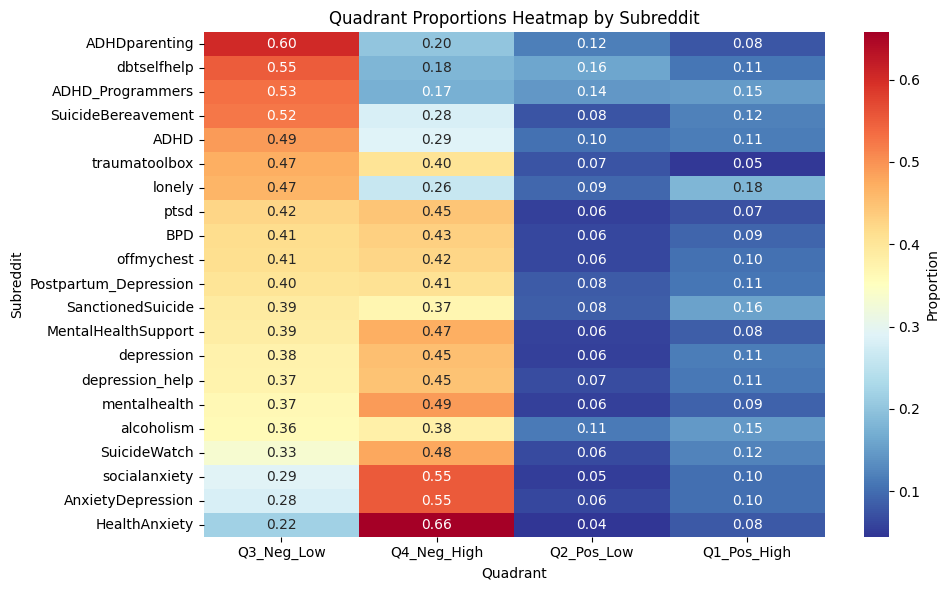


Overall average quadrant proportions across all subreddits:
Q3_Neg_Low     0.413
Q4_Neg_High    0.398
Q2_Pos_Low     0.081
Q1_Pos_High    0.108
dtype: float64


In [28]:
import seaborn as sns

# 1️⃣ Heatmap of valence–arousal quadrant mix
plt.figure(figsize=(10,6))
sns.heatmap(
    quad_prop.set_index("subreddit")[["Q3_Neg_Low","Q4_Neg_High","Q2_Pos_Low","Q1_Pos_High"]],
    cmap="RdYlBu_r", annot=True, fmt=".2f", cbar_kws={"label":"Proportion"}
)
plt.title("Quadrant Proportions Heatmap by Subreddit")
plt.ylabel("Subreddit")
plt.xlabel("Quadrant")
plt.tight_layout()

fig_path = os.path.join(OUT_DIR, "quadrant_heatmap_by_subreddit.png")
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
print(f"✅ Saved heatmap → {fig_path}")
plt.show()

# 2️⃣ Optional overall averages
overall = quad_prop[["Q3_Neg_Low","Q4_Neg_High","Q2_Pos_Low","Q1_Pos_High"]].mean().round(3)
print("\nOverall average quadrant proportions across all subreddits:")
print(overall)